# IMPORTS

## Standards

In [26]:
from pathlib import Path
import warnings

## Externals

In [27]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

# CONFIGS

## Folders

In [28]:
ROOT = Path("../")
DATA = str(ROOT / "assets")

## Tesseract

In [29]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
CONFIG = "--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789"

# OPTIONS

## Matplotlib

In [30]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.style.use("seaborn-v0_8-darkgrid")

## Warnings

In [31]:
warnings.filterwarnings("ignore")

# DATA

In [32]:
EXAMPLE = f"{DATA}/examples/1.jpg"
MASK = f"{DATA}/mask.png"

# IMAGE PROCESSING

In [33]:
def preprocess_image(image):
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  original = img.copy()
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  blur = cv2.GaussianBlur(gray, (5,5), 0)
  thresh = cv2.adaptiveThreshold(blur, 255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 11, 2)
  return original, gray, blur, thresh

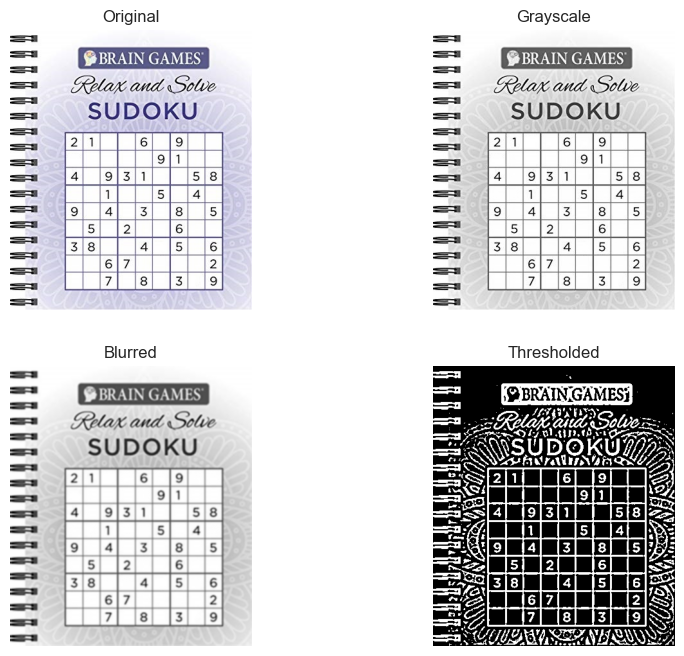

In [34]:
image = cv2.imread(EXAMPLE)
original, gray, blur, thresh = preprocess_image(image)

plt.subplot(221), plt.imshow(original), plt.title("Original"), plt.axis('off')
plt.subplot(222), plt.imshow(gray, cmap='gray'), plt.title("Grayscale"), plt.axis('off')
plt.subplot(223), plt.imshow(blur, cmap='gray'), plt.title("Blurred"), plt.axis('off')
plt.subplot(224), plt.imshow(thresh, cmap='gray'), plt.title("Thresholded"), plt.axis('off')
plt.show()

# GRID DETECTION

In [35]:
def find_grid_contour(thresh_image):
  # Find contours
  contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)

  # Find largest quadrilateral
  for cnt in contours:
      peri = cv2.arcLength(cnt, True)
      approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
      if len(approx) == 4:
          return approx.reshape(4, 2)
  return None


def perspective_transform(image, points):
  # Order points: top-left, top-right, bottom-right, bottom-left
  rect = np.zeros((4, 2), dtype="float32")
  s = points.sum(axis=1)
  rect[0] = points[np.argmin(s)]
  rect[2] = points[np.argmax(s)]

  diff = np.diff(points, axis=1)
  rect[1] = points[np.argmin(diff)]
  rect[3] = points[np.argmax(diff)]

  (tl, tr, br, bl) = rect
  width = max(np.linalg.norm(tr - tl), np.linalg.norm(br - bl))
  height = max(np.linalg.norm(bl - tl), np.linalg.norm(br - tr))

  dst = np.array([[0,0], [width-1,0], [width-1,height-1], [0,height-1]], dtype="float32")
  M = cv2.getPerspectiveTransform(rect, dst)
  warped = cv2.warpPerspective(image, M, (int(width), int(height)))

  return warped, M

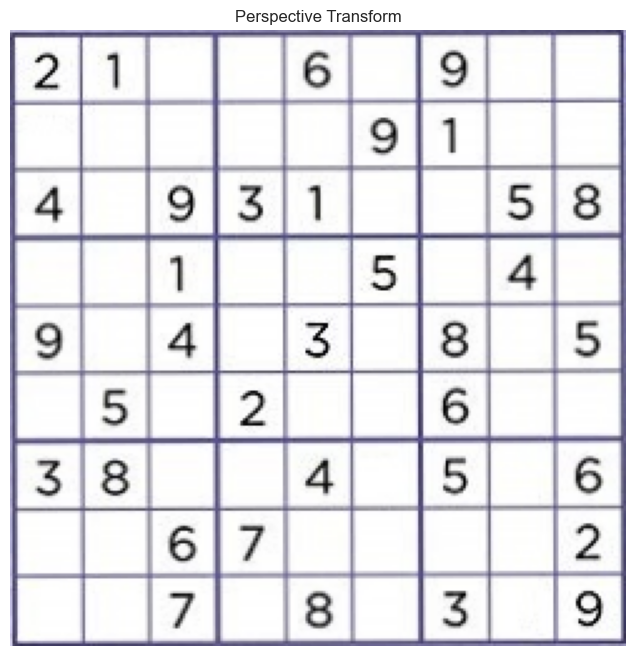

In [36]:
grid_contour = find_grid_contour(thresh)
warped, M = perspective_transform(original, grid_contour)

plt.imshow(warped), plt.title("Perspective Transform"), plt.axis('off')
plt.show()

# CELL EXTRACTION

In [37]:
def extract_cells(warped_image):
  cell_size = warped_image.shape[0] // 9
  rows = np.array_split(warped_image, 9, axis=0)
  cells = []
  for row in rows:
      cols = np.array_split(row, 9, axis=1)
      for cell in cols:
          cell = cv2.resize(cell, (28, 28))
          cells.append(cell)
  return np.array(cells), cell_size

27


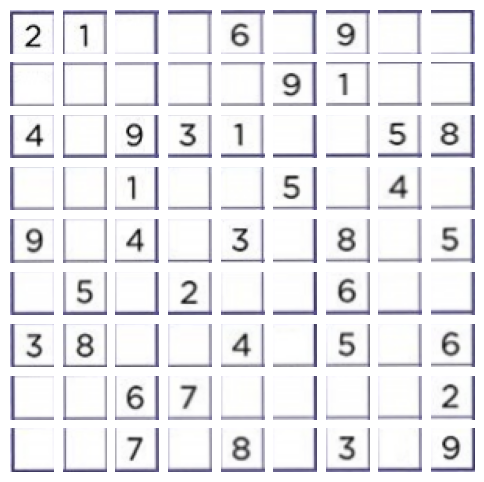

In [38]:
cells, cell_size = extract_cells(warped)

print(cell_size)
plt.figure(figsize=(6, 6))
for i in range(9):
    for j in range(9):
        plt.subplot(9, 9, i*9 + j + 1)
        plt.imshow(cells[i*9 + j], cmap='gray')
        plt.axis('off')
plt.show()

# CELL PROCESSING

In [39]:
def process_cells(cells, mask):
  processed_cells = []
  for cell in cells:
      cell = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
      _, cell = cv2.threshold(cell, 0, 255, cv2.THRESH_OTSU)

      resized_mask = cv2.resize(mask, (cell.shape[1], cell.shape[0]))
      cell = cv2.bitwise_or(cell, resized_mask)

      processed_cells.append(cell)
  return processed_cells

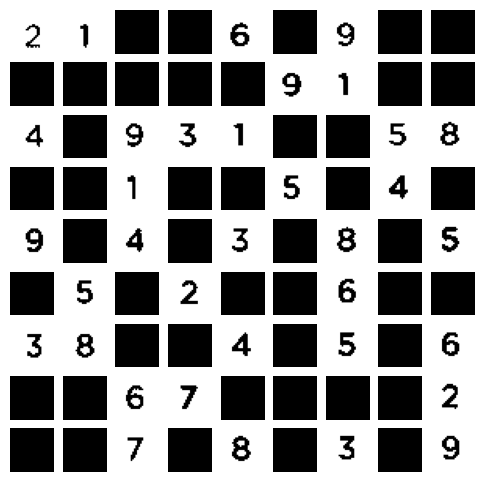

In [40]:
mask = cv2.imread(MASK, 0)
processed_cells = process_cells(cells, mask)

plt.figure(figsize=(6, 6))
for i, box in enumerate(processed_cells):
    plt.subplot(9, 9, i + 1)
    plt.imshow(box, cmap='gray')
    plt.axis('off')
plt.show()

# DIGIT RECOGNITION

In [41]:
def read_digits(cells):
  result = []
  for cell in cells:
      text = pytesseract.image_to_string(cell, config=CONFIG)
      text = text.strip()
      if text.isdigit():
          digit = int(text)
      else:
          digit = 0
      result.append(digit)
  result = np.array(result).reshape(9, 9)
  return result

In [42]:
sudoku_grid = read_digits(processed_cells)

print("Recognized Sudoku:")
print(sudoku_grid)

Recognized Sudoku:
[[2 1 0 0 6 0 9 0 0]
 [0 0 0 0 0 9 1 0 0]
 [4 0 9 3 1 0 0 5 8]
 [0 0 1 0 0 5 0 4 0]
 [9 0 4 0 3 0 8 0 0]
 [0 5 0 2 0 0 6 0 0]
 [3 8 0 0 4 0 5 0 6]
 [0 0 6 7 0 0 0 0 2]
 [0 0 7 0 8 0 3 0 9]]


In [43]:
positions = np.where(sudoku_grid > 0, 0, 1)
print(positions)

[[0 0 1 1 0 1 0 1 1]
 [1 1 1 1 1 0 0 1 1]
 [0 1 0 0 0 1 1 0 0]
 [1 1 0 1 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 1]
 [1 0 1 0 1 1 0 1 1]
 [0 0 1 1 0 1 0 1 0]
 [1 1 0 0 1 1 1 1 0]
 [1 1 0 1 0 1 0 1 0]]


# SUDOKU SOLVING

In [44]:
def is_valid(board, row, col, num):
  if num in board[row]:
      return False
  if num in board[:, col]:
      return False
  start_row, start_col = row - row % 3, col - col % 3
  if num in board[start_row:start_row + 3, start_col:start_col + 3]:
      return False
  return True

In [45]:
def explore_solutions(board):
  for row in range(9):
      for col in range(9):
          if board[row, col] == 0:
              for num in range(1, 10):
                  if is_valid(board, row, col, num):
                      board[row, col] = num
                      if explore_solutions(board):
                          return True
                      board[row, col] = 0
              return False
  return True

In [46]:
def solve(board):
  if explore_solutions(board):
      return board
  else:
      return "No solution exists."

In [47]:
solved_grid = solve(sudoku_grid)
print(solved_grid)

[[2 1 5 4 6 8 9 3 7]
 [7 3 8 5 2 9 1 6 4]
 [4 6 9 3 1 7 2 5 8]
 [6 2 1 8 9 5 7 4 3]
 [9 7 4 1 3 6 8 2 5]
 [8 5 3 2 7 4 6 9 1]
 [3 8 2 9 4 1 5 7 6]
 [1 9 6 7 5 3 4 8 2]
 [5 4 7 6 8 2 3 1 9]]


# SOLUTION OVERLAY

In [48]:
def overlay_solution(original_img, warped_img, solution_grid, positions, M, cell_size):
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    scale = cell_size / 28
    color = (0, 255, 0)

    height, width = warped_img.shape[:2]
    solution_img = np.zeros_like(warped_img)
    solution_grid = np.multiply(positions, solution_grid)
    for i in range(9):
        for j in range(9):
            if solution_grid[i][j] != 0:
                x = int((j + 0.3) * cell_size)
                y = int((i + 0.8) * cell_size)
                cv2.putText(solution_img, str(solution_grid[i][j]), (x, y), font, scale, color, 1, cv2.LINE_8)

    # Inverse perspective transform
    inv_M = cv2.getPerspectiveTransform(
        np.array([[0, 0], [0, height], [width, height], [width, 0]], dtype="float32"),
        grid_contour.astype("float32"))
    inv_warped = cv2.warpPerspective(solution_img, inv_M, (original_img.shape[1], original_img.shape[0]))

    # Create mask from non-black pixels in the warped solution image
    gray = cv2.cvtColor(inv_warped, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Extract foreground (green text) and background (original image)
    fg = cv2.bitwise_and(inv_warped, inv_warped, mask=mask)
    bg = cv2.bitwise_and(original_img, original_img, mask=cv2.bitwise_not(mask))
    result = cv2.add(bg, fg)

    return result

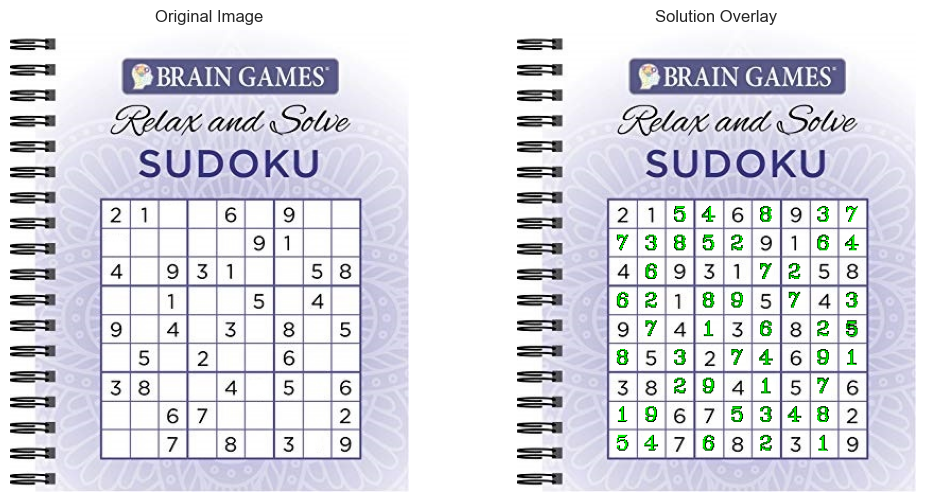

In [49]:
final_image = overlay_solution(original, warped, solved_grid, positions, M, cell_size)

plt.figure(figsize=(12,6))
plt.subplot(121), plt.imshow(original), plt.title("Original Image"), plt.axis('off')
plt.subplot(122), plt.imshow(final_image), plt.title("Solution Overlay"), plt.axis('off')
plt.show()